> Faros Antonios, Student <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> 8160139<br />
> antonis.faros@gmail.com

# Clustering and Classification of MEPs' Tweets

You will investigate a dataset of tweets made by Members of the European Parliament. You will use data collected by Darko Cherepnalkoski, Andreas Karpf, Igor Mozetič, and Miha Grčar for their paper [Cohesion and Coalition Formation in the European Parliament: Roll-Call Votes and Twitter Activities](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0166586)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

## Data Preparation

* Get the dataset from <https://www.clarin.si/repository/xmlui/handle/11356/1071>.


* You will use the `retweets.csv` file.

In [4]:
import os.path
from os import path
flag = True
if path.exists("MEP_tweets2.csv"):
    flag = False

In [5]:
if (flag):
    data_filename = 'retweets.csv'
    data = pd.read_csv(data_filename)
    data = data.loc[data.lang == 'en']
    tweet_ids = data.origTweetId
    tweet_ids =tweet_ids.to_list()
    data.shape

* Keep only the records for which the language of the original tweet is in English.


* Get the text of the *original tweet* and add it to the dataset as an extra column. Use the Tweeter API to get the text (e.g., with Tweepy). In order not to run into rate limits you can ask for multiple tweets with one call.

In [6]:
import tweepy

In [7]:
#adopted from https://stackoverflow.com/questions/44581647/retrieving-a-list-of-tweets-using-tweet-id-in-tweepy
#and modified to fit the specific case
def lookup_tweets(tweet_IDs, api):
    full_tweets = []
    tweet_count = len(tweet_IDs)
    try:
        for i in range(int(tweet_count / 100) + 1):
            # Catch the last group if it is less than 100 tweets
            end_loc = min((i + 1) * 100, tweet_count)
            full_tweets.extend(
                api.statuses_lookup(id_ = tweet_IDs[i * 100:end_loc])
            )
        return full_tweets
    except tweepy.TweepError:
        print ('Something went wrong, quitting...')

In [8]:
if (flag):
    twitter_keys = {
            'consumer_key':        '--Your Key goes here--',
            'consumer_secret':     '--Your Key goes here--',
            'access_token_key':    '--Your Key goes here--',
            'access_token_secret': '--Your Key goes here--'
        }

    #Setup access to API
    auth = tweepy.OAuthHandler(twitter_keys['consumer_key'], twitter_keys['consumer_secret'])
    auth.set_access_token(twitter_keys['access_token_key'], twitter_keys['access_token_secret'])

    api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    results = lookup_tweets(tweet_ids, api)

We will convert the output to json format in order to better handle it afterwards

In [9]:
if (flag):
    import json
    temp = json.dumps([status._json for status in results]) #create JSON
    newdf = pd.read_json(temp, orient='records')
    texts = newdf[['id','text']]
    fin_data = pd.merge(left = data,right = texts,left_on= 'origTweetId',right_on= 'id',how ='inner').drop('id', axis=1)

* Keep only the records for which you were able to download the tweet text.
* We remove the same tweets in the dataframe
* Those tweets may have been posted multiple times for some reason and we will not take them into consideration.

In [10]:
if (flag):
    df= fin_data
    df = df.drop_duplicates(subset='text', keep="last")
    df = df[df.text.notnull()]
    df.shape

We save a copy of the requested texts to a csv file in order to not access the Twitter Api every time we run the notebook

In [11]:
if (flag):
    file_name = 'MEP_tweets2.csv'
    df.to_csv(file_name)
    grouped_mep = df.groupby(df.origMepGroupShort)

* Group the records by the European group of the MEP that posted the original tweet. If you see that there are groups with very few tweets (less than 50), drop them. 

In [12]:
if (flag):
    grouped_mep.count()

We notice that only one member of **NI** has written a tweet so we will not consider it.

Also we will not consider the tweets from **ENL** beacause they are too few. 

* We will continue by reading the data from the downloaded csv file in order to not access Twitter's API each time we re-run the notebook.

In [13]:
import re
data_filename = 'MEP_tweets2.csv'
offline_data = pd.read_csv(data_filename)
offline_data=offline_data.loc[offline_data.origMepGroupShort != 'ENL']
offline_data=offline_data.loc[offline_data.origMepGroupShort != 'NI']
df1 = pd.DataFrame(list(zip(offline_data['text'], offline_data['origMepGroupId'])), columns=['text', 'label'])
df1['text'] = df1['text'].apply(lambda x: re.split('@\S+|https?://\S+', str(x))[0])#Clean the text from URLs and mentions

* We also  modify the English words frozen set by adding words that are very common the specific domain.

In [14]:
from sklearn.feature_extraction import text
my_words = {'europe','european','union','eu','amp','today','new','people',
            'mep','vote','don','does','doesn','great','good','vote','ep','day','just','want','need','meps'}
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_words)


* We will remove possible occuring accents and also convert everything to lowercase.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
vectorizer = CountVectorizer(min_df = 10,max_df =0.5 ,stop_words =my_stop_words,strip_accents = 'unicode',lowercase =True)
corpus= df1.text

In [189]:
vectorizer.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.5, max_features=None, min_df=10,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'amp', 'an', 'and', 'another', 'any',
                                      'anyhow', 'anyone', 'anything', 'anyway', ...}),
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [190]:
X = vectorizer.transform(corpus)
X

<10102x1333 sparse matrix of type '<class 'numpy.int64'>'
	with 39323 stored elements in Compressed Sparse Row format>

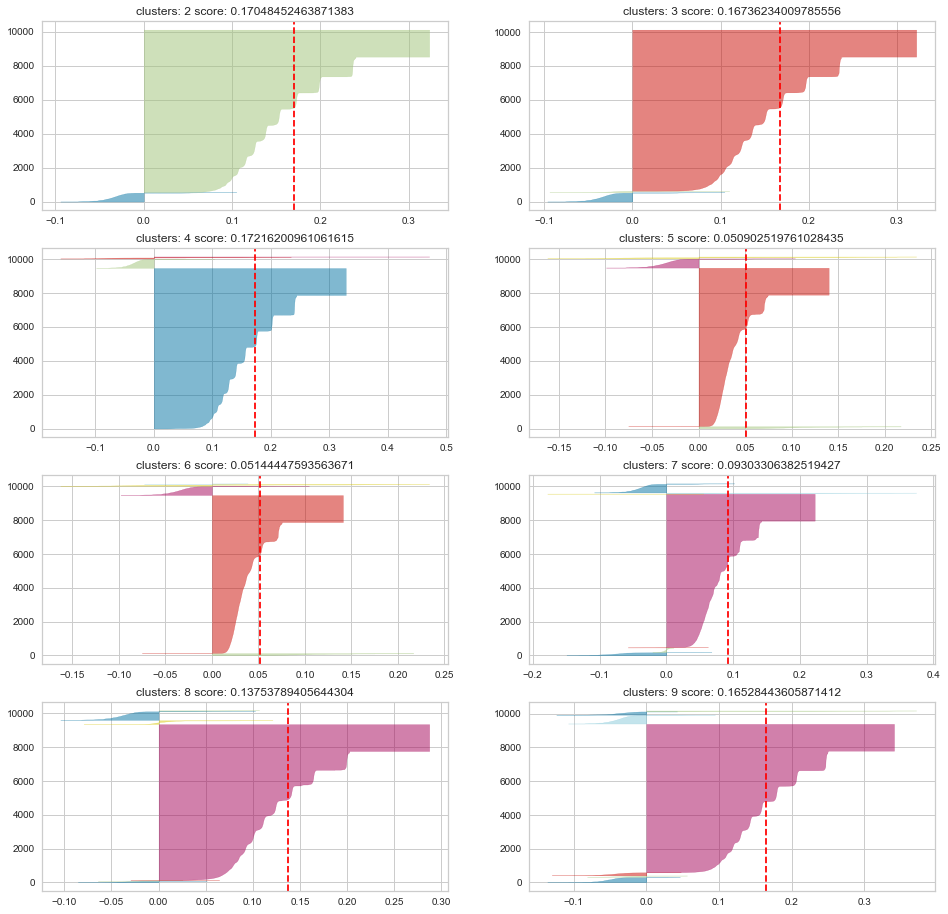

In [191]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
best_kmeans = None
best_score = -1
for n_clusters in range(2, 10):
    plt.subplot(4, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters,random_state = 0)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    scores[n_clusters] = visualizer.silhouette_score_
    if visualizer.silhouette_score_ > best_score:
        best_score = visualizer.silhouette_score_
        best_kmeans = kmeans
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

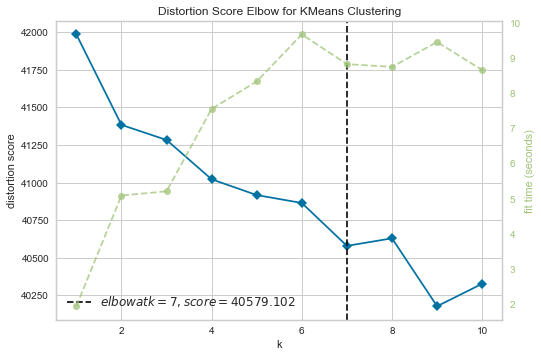

In [192]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,11))

visualizer.fit(X)
visualizer.show()

* We identify the number of clusters to be $9$ because both the elbow method and the silhouette give good results for 9 clusters.


* We also tried several other cleaning techniques(such as also removing hashtags and emojis) on the text data in order to achieve higher silhouette scores but the results were not satisfying. 


* For those reasons we decide to use the Kmeans algorithms with 9 clusters.

In [195]:
kmeans = KMeans(n_clusters=9,random_state =0)
tweets =kmeans.fit(X)


* We will now identify the topics provided by the K Means clustering by printing the most common words in each of them.

In [196]:
n_top_words = 20
print("Topics in the Kmeans model:")
c_feature_names = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(tweets.cluster_centers_):
    print(f"Topic {topic_idx}")
    sorted_topics_indcs = (-topic).argsort()[:n_top_words]
    feature_names = [ c_feature_names[i] for i in sorted_topics_indcs ]
    feature_counts = topic[sorted_topics_indcs]
    print(" ".join([ f'{fn} {fc:.2f}' for fn, fc in zip(feature_names, feature_counts)]))
    print()

Topics in the Kmeans model:
Topic 0
uk 1.04 ukip 0.07 leave 0.05 migrants 0.05 steel 0.04 govt 0.04 brexit 0.04 referendum 0.04 labour 0.04 time 0.04 migration 0.04 jobs 0.04 year 0.04 outside 0.04 trade 0.04 tories 0.03 policy 0.03 work 0.03 membership 0.03 let 0.03

Topic 1
greek 1.05 greece 0.24 govt 0.16 tsipras 0.11 government 0.11 pm 0.09 grexit 0.05 real 0.05 help 0.05 imf 0.05 economic 0.05 minister 0.05 responsibility 0.05 live 0.04 debt 0.04 decide 0.04 democracy 0.04 hear 0.04 say 0.04 ecb 0.04

Topic 2
greece 1.01 tsipras 0.20 euro 0.12 eurozone 0.09 yes 0.06 grexit 0.06 reforms 0.05 future 0.04 parliament 0.04 reform 0.04 deal 0.04 democracy 0.04 syriza 0.04 debt 0.04 currency 0.03 pm 0.03 imf 0.03 ecb 0.03 italy 0.03 needs 0.03

Topic 3
ttip 0.03 parliament 0.03 labour 0.02 meeting 0.02 debate 0.02 support 0.02 thanks 0.02 says 0.01 right 0.01 work 0.01 britain 0.01 time 0.01 migration 0.01 trade 0.01 refugees 0.01 speech 0.01 rights 0.01 let 0.01 ukraine 0.01 year 0.01



* The $1st$ topic (**Topic 0**)  seems to refer to brexit .

 
* The $2nd$  and $3rd$ topics (**Topic 1,2**) seems to refer to the greek crisis and the possibility of grexit.
 

* The $4th$ topic (**Topic 3**) seems to refer to the Translatic Trade and Investment Partnership(ttip) and the debate EU commision had regarding it , more info : https://www.europarl.europa.eu/news/en/headlines/eu-affairs/20150610STO65005/ep-vote-and-debate-on-ttip-recommendations-postponed-what-s-next


* The $6th$ topic (**Topic 5**)seems to refer to the UK Independence Party (ukip) and the NHS policies ,more info at : https://www.ukip.org/ukip-manifesto-item.php?cat_id=1


* The $7th$ (**Topic 6**) topic seems to refer to britain migration policy.


* The $8th$ (**Topic 7**) seems to refer to the russian military intervention in Ukraine ,more information : https://en.wikipedia.org/wiki/Russian_military_intervention_in_Ukraine_(2014%E2%80%93present)


* The other two topics are not very specific.


* After various experimentations with clustering parameters we were also able to Identify topics such as : **Meat Labeling and Food Security, Paris Agreement on Climate Change, Border Control and Roaming charges in the EU.** 


We will be using Yellowbricks InterCluster Distance to visualize the clusters in two dimensions

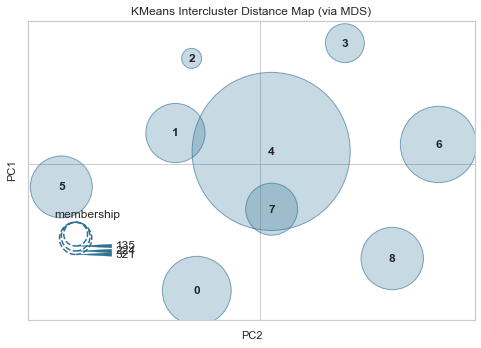

In [208]:
from yellowbrick.cluster import InterclusterDistance
model = KMeans(9,random_state =42)
visualizer = InterclusterDistance(model)
visualizer.fit(X)      
visualizer.show()

* We also tried to investigate the results using Bi-grams instead, but the results were not satisfyiing either.



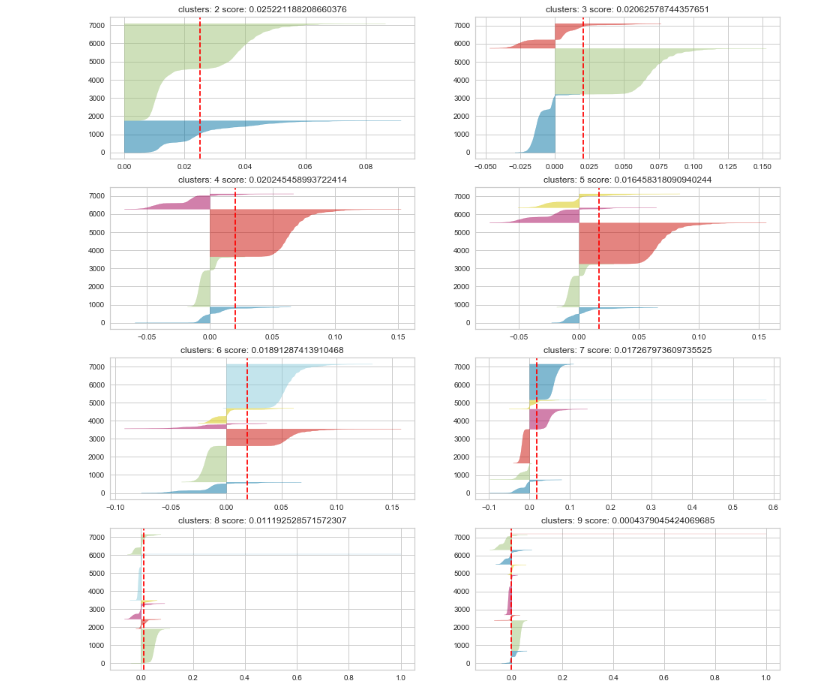

In [14]:
from IPython.display import Image
Image(filename='Bi-gram_Silhouette_Score.png')

As seen from the results above we did not achieve a greater clustering

* We will also try an approach using TF-idf Vectorizer

In [204]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfvectorizer = TfidfVectorizer(min_df = 10,max_df =0.5 ,stop_words =my_stop_words,strip_accents = 'unicode',lowercase =True)
X_2= tfvectorizer.fit_transform(corpus)

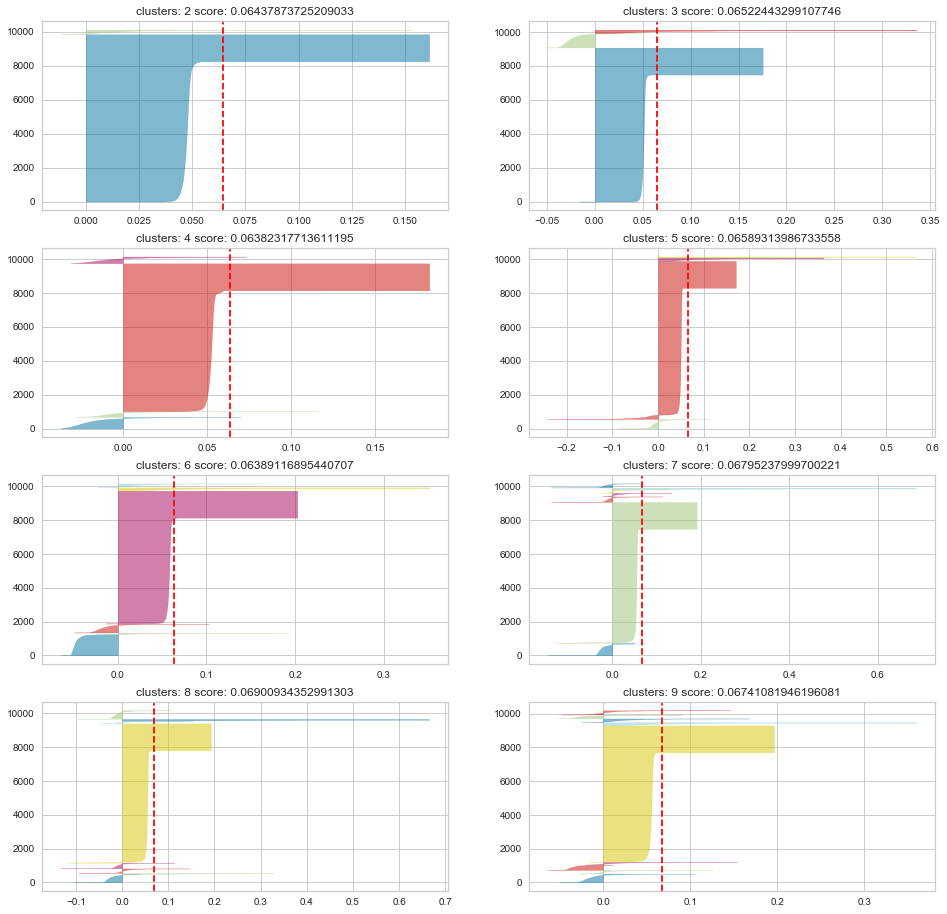

In [206]:
plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
best_kmeans = None
best_score = -1
for n_clusters in range(2, 10):
    plt.subplot(4, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters,random_state = 0)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X_2)
    scores[n_clusters] = visualizer.silhouette_score_
    if visualizer.silhouette_score_ > best_score:
        best_score = visualizer.silhouette_score_
        best_kmeans = kmeans
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

* Seems that we do not get better results so we will not investigate it further.

## Classification

* Train at least two algorithms to learn to classify an unseen tweet. The target variable should be the political party of the original poster and the training features should be the original tweet's text.

* You should split your data to training and testing datasets, try the different algorithms with cross validation on the training dataset, and find the best hyperparameters for the best algorithm. The best hyperparameters for the construction of the bag of words or tf-idf matrices for classification are not necessarily the same with those you used for k-means.

* Report your scores; once you find the best algorithm and the best hyperparameters, report the score on the test data.

* To gauge the efficacy of the algorithm, report also the results of a baseline classifier, using, for instance, scikit-learn's [`DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html).

In [3]:
cldf = pd.DataFrame(list(zip(offline_data['text'], offline_data['origMepGroupId'])), columns=['data', 'target'])
cldf['data'] = cldf['data'].apply(lambda x: re.split('https?://\S+', str(x))[0])# We will not remove mentions for the following algorithms

In [4]:
X_1,y_1 =cldf.data,cldf.target

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_1, y_1, test_size=0.15, random_state=42,shuffle = True)

In [6]:
labels = {0: 'GUE-NGL',1: 'S&D',2:'Greens-EFA',3:'ALDE',4:'EPP',5:'ECR',6:'EFDD'}

* As a start we will measure the results of a Dummy Classiffier in order to have a benchmark for our classifiers.

In [7]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_1, y_1)
dummy_clf.predict(X_1)
dummy_clf.score(X_1, y_1)

0.23935854286279945

* We need to get significantly better results than 0.24 in order for our classifiers to be worthy.


* Lets start by implementing a **Multinomial Naive Bayes** Classifier 

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
    

In [11]:
text_clf = Pipeline([('vect', CountVectorizer(strip_accents = 'unicode',lowercase =True,stop_words ='english')),
                    ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test) 

0.5448548812664907

In [12]:
from sklearn.metrics import classification_report

In [13]:
print(classification_report(y_test, predicted,target_names = labels.values()))

              precision    recall  f1-score   support

     GUE-NGL       0.00      0.00      0.00        41
         S&D       0.43      0.81      0.56       331
  Greens-EFA       0.83      0.03      0.07       147
        ALDE       0.66      0.29      0.40       219
         EPP       0.71      0.58      0.64       255
         ECR       0.82      0.06      0.11       150
        EFDD       0.59      0.90      0.71       373

    accuracy                           0.54      1516
   macro avg       0.58      0.38      0.35      1516
weighted avg       0.61      0.54      0.48      1516



C:\Users\tfaro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predicted))

[[  0  28   0   1   1   0  11]
 [  0 268   0   6   9   0  48]
 [  0  81   5   9  16   0  36]
 [  0  94   0  63  19   2  41]
 [  0  65   1  10 147   0  32]
 [  0  57   0   6  11   9  67]
 [  0  35   0   1   3   0 334]]


* Lets try to optimise it by searching for better hyperparameters

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'vect__max_df':(0.5,0.7,0.9,1.0,0.3),
              'vect__min_df': (1,5,10,20),
              'clf__alpha': (1e-2,1e-1,1)
              
             }

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)

In [17]:
gs_clf = gs_clf.fit(X_train, y_train)

In [18]:
gs_clf.best_params_

{'clf__alpha': 0.01,
 'tfidf__use_idf': False,
 'vect__max_df': 0.5,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 2)}

In [19]:
predicted_gs = gs_clf.predict(X_test)
np.mean(predicted_gs == y_test)

0.6220316622691293

In [20]:
print(classification_report(y_test, predicted_gs,target_names = labels.values()))

              precision    recall  f1-score   support

     GUE-NGL       0.84      0.39      0.53        41
         S&D       0.58      0.72      0.64       331
  Greens-EFA       0.51      0.28      0.36       147
        ALDE       0.56      0.52      0.54       219
         EPP       0.59      0.67      0.63       255
         ECR       0.57      0.31      0.40       150
        EFDD       0.73      0.85      0.78       373

    accuracy                           0.62      1516
   macro avg       0.63      0.53      0.56      1516
weighted avg       0.62      0.62      0.61      1516



* We can definately see an improvement in the results because the accuracy increased to 62%

In [21]:
print(confusion_matrix(y_test, predicted_gs))

[[ 16  11   2   2   3   1   6]
 [  1 239  12  18  22   6  33]
 [  0  36  41  24  32   4  10]
 [  1  34  11 114  30  11  18]
 [  1  37   8  24 170   4  11]
 [  0  23   3  15  22  46  41]
 [  0  31   4   6   7   8 317]]


* Let's also check the results of a **Support Vector Machines** Classifier

In [22]:
from sklearn.svm import SVC
text_clf = Pipeline([('vect', CountVectorizer(stop_words ='english',strip_accents = 'unicode',lowercase =True)),
                    ('tfidf', TfidfTransformer()),
                     ('clf',SVC(C=1, kernel='linear')),# We use linear kernel because it is faster and  
                    ])                                           #recommended for text classification

text_clf.fit(X_train, y_train)
predicted_svc = text_clf.predict(X_test)
np.mean(predicted_svc == y_test)

0.6081794195250659

In [23]:
print(classification_report(y_test, predicted_svc,target_names = labels.values()))

              precision    recall  f1-score   support

     GUE-NGL       0.82      0.44      0.57        41
         S&D       0.51      0.76      0.61       331
  Greens-EFA       0.53      0.25      0.34       147
        ALDE       0.54      0.52      0.53       219
         EPP       0.69      0.58      0.63       255
         ECR       0.66      0.29      0.41       150
        EFDD       0.70      0.83      0.76       373

    accuracy                           0.61      1516
   macro avg       0.63      0.52      0.55      1516
weighted avg       0.62      0.61      0.59      1516



In [24]:
print(confusion_matrix(y_test, predicted_svc))

[[ 18  16   2   3   0   0   2]
 [  1 252   6  19  16   4  33]
 [  0  48  37  20  23   3  16]
 [  1  51  12 113  14   7  21]
 [  1  49   6  34 149   2  14]
 [  0  29   4  17  12  44  44]
 [  1  45   3   5   3   7 309]]


In [276]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_df':(0.5,0.7),
              'vect__min_df': (1,5,10),
              
             }

gssvc_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)

In [277]:
gssvc_clf = gssvc_clf.fit(X_train, y_train)

In [278]:
gssvc_clf.best_params_

{'vect__max_df': 0.5, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}

In [279]:
predicted_gssvc = gssvc_clf.predict(X_test)
np.mean(predicted_gssvc == y_test)

0.6174142480211082

In [280]:
print(classification_report(y_test, predicted_gssvc,target_names = labels.values()))

              precision    recall  f1-score   support

     GUE-NGL       0.83      0.46      0.59        41
         S&D       0.53      0.76      0.62       331
  Greens-EFA       0.61      0.25      0.36       147
        ALDE       0.56      0.53      0.54       219
         EPP       0.68      0.60      0.64       255
         ECR       0.64      0.29      0.40       150
        EFDD       0.70      0.84      0.76       373

    accuracy                           0.62      1516
   macro avg       0.65      0.53      0.56      1516
weighted avg       0.63      0.62      0.60      1516



* Our next approach will be with a **Random forest**

In [259]:
from sklearn.ensemble import RandomForestClassifier

In [261]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words =my_stop_words,strip_accents = 'unicode',lowercase =True,min_df =1,
                                              max_df = 0.1,ngram_range=(1,1))),
                     ('tfidf', TfidfTransformer()),
                     ('clf',RandomForestClassifier(random_state = 42, min_samples_leaf =2,
                                                   min_samples_split = 15,bootstrap =True,max_depth =450,
                                                   n_estimators = 500)),  #Hyperparameters tuning done after experimenting
                                                                          #with different values, Grid search would have to fit 39600 models 
                                                                          #so we avoided it.
                      ])                                           

text_clf.fit(X_train, y_train)
predicted_dt = text_clf.predict(X_test)
np.mean(predicted_dt == y_test)

0.5686015831134564

In [281]:
print(classification_report(y_test, predicted_dt,target_names = labels.values()))


              precision    recall  f1-score   support

     GUE-NGL       0.75      0.44      0.55        41
         S&D       0.48      0.66      0.56       331
  Greens-EFA       0.55      0.24      0.33       147
        ALDE       0.49      0.38      0.43       219
         EPP       0.62      0.60      0.61       255
         ECR       0.70      0.26      0.38       150
        EFDD       0.63      0.84      0.72       373

    accuracy                           0.57      1516
   macro avg       0.60      0.49      0.51      1516
weighted avg       0.58      0.57      0.55      1516



In [282]:
print(confusion_matrix(y_test, predicted_dt))

[[ 18  16   1   1   1   0   4]
 [  1 219   8  21  21   6  55]
 [  0  41  35  22  24   2  23]
 [  3  51   8  84  29   3  41]
 [  2  55   7  20 154   1  16]
 [  0  33   1  13  16  39  48]
 [  0  40   4   9   2   5 313]]


* Last we will try by using **XGBoost**

In [284]:
import xgboost as xgb

In [291]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words ='english',strip_accents = 'unicode',lowercase =True,
                                              min_df =1,max_df = 0.5,ngram_range=(1,2) )),
                    ('tfidf', TfidfTransformer(use_idf = False)),
                     ('clf',xgb.XGBClassifier(random_state =1, learning_rate = 1)),  
                    ])                                           

text_clf.fit(X_train, y_train)
predicted_xgb = text_clf.predict(X_test)
np.mean(predicted_xgb == y_test)

0.5606860158311345

In [292]:
print(classification_report(y_test, predicted_xgb,target_names = labels.values()))

              precision    recall  f1-score   support

     GUE-NGL       0.69      0.44      0.54        41
         S&D       0.49      0.69      0.57       331
  Greens-EFA       0.37      0.27      0.31       147
        ALDE       0.53      0.38      0.44       219
         EPP       0.65      0.56      0.61       255
         ECR       0.42      0.31      0.36       150
        EFDD       0.68      0.77      0.72       373

    accuracy                           0.56      1516
   macro avg       0.55      0.49      0.51      1516
weighted avg       0.56      0.56      0.55      1516



#### The best result we managed to obtain was 62%, further experimentation with Grid Search might have improved the result even more.